In [12]:
import random
from Snake import SnakeGame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import functools
from IPython.display import HTML

In [13]:
def evaluateScore(Q, boardDim, numRuns, displayGame=False):
    # Run the game for a specified number of runs given a specific Q matrix
    cutoff = 100  # X moves without increasing score will cut off this game run
    scores = []
    for i in range(numRuns):
        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        score = 0
        oldScore = 0
        gameOver = False
        moveCounter = 0
        while not gameOver:
            possibleQs = Q[state, :]
            action = np.argmax(possibleQs)
            state, reward, gameOver, score = game.makeMove(action)
            if score == oldScore:
                moveCounter += 1
            else:
                oldScore = score
                moveCounter = 0
            if moveCounter >= cutoff:
                # stuck going back and forth
                break
        scores.append(score)
    return np.average(scores), scores

### TD Learning Methods

In [14]:
def QLearning(numEpisodes=10001, boardDim=16, lr=0.9, gamma=0.8, epsilon=0.2):
    # Performs off-policy Q-Learning Algorithm using snake game environment defined in Snake.py
    # state =  (top blocked, right blocked, down blocked, left blocked, up food, right food, down food, left food)
    numStates = 2**8
    numActions = 4  # 4 directions that the snake can move
    Q = np.zeros((numStates, numActions))
    Qs = np.zeros([numEpisodes, numStates, numActions])
    bestLength = 0
    print("Training for", numEpisodes, "games...")
    for episode in range(numEpisodes):
        #    print("New Game")
        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        gameOver = False
        score = 0
        while not gameOver:
            if random.uniform(0, 1) < epsilon:
                action = random.randint(0, 3)
            else:
                possibleQs = Q[state, :]
                action = np.argmax(possibleQs)
            new_state, reward, gameOver, score = game.makeMove(action)

            Q[state, action] = Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
            state = new_state
        Qs[episode, :, :] = np.copy(Q)
        if episode % 100 == 0:
            averageLength, lengths = evaluateScore(Q, boardDim, 25)
            if averageLength > bestLength:
                bestLength = averageLength
                bestQ = np.copy(Q)
            print("Episode", episode, "Average snake length:", averageLength)
    return Qs

def Sarsa(numEpisodes=10001, boardDim=16, lr=0.9, gamma=0.8, epsilon=0.2):
    # Performs on-policy Sarsa Algorithm using snake game environment defined in Snake.py
    numStates = 2**8
    numActions = 4  # 4 directions that the snake can move
    Q = np.zeros((numStates, numActions))
    Qs = np.zeros([numEpisodes, numStates, numActions])
    bestLength = 0
    print("Training for", numEpisodes, "games...")
    for episode in range(numEpisodes):

        game = SnakeGame(boardDim, boardDim)
        state = game.calcStateNum()
        action = random.randint(0, 3)
        gameOver = False
        score = 0
        while not gameOver:
            if random.uniform(0, 1) < epsilon:
                new_action = random.randint(0, 3)
            else:
                possibleQs = Q[state, :]
                new_action = np.argmax(possibleQs)
            new_state, reward, gameOver, score = game.makeMove(action)

            Q[state, action] = Q[state, action]  + lr * (reward + gamma * Q[new_state][new_action] - Q[state, action]) 
            state = new_state
            action = new_action

        Qs[episode, :, :] = np.copy(Q)
        if episode % 100 == 0:
            averageLength, lengths = evaluateScore(Q, boardDim, 25)
            if averageLength > bestLength:
                bestLength = averageLength
                bestQ = np.copy(Q)
            print("Episode", episode, "Average snake length:", averageLength)
    return Qs

### Animation

In [15]:
def generate_plot(Qs, boardDim=16):
    #Animate games at different episodes
    print("Generating data for animation...")
    plotEpisodes = [0, 200, 400, 600, 800, 1000, 2500, 5000, 10000]
    fig, axes = plt.subplots(3, 3, figsize=(9,9))

    axList = []
    ims = []
    dataArrays = []
    scores = []
    labels = []

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            ax.set_title("Episode " + str(plotEpisodes[i*len(row) + j]))
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            axList.append(ax)
            ims.append(ax.imshow(np.zeros([boardDim, boardDim]), vmin=-1, vmax=1, cmap='RdGy'))
            labels.append(ax.text(0,15, "Length: 0", bbox={'facecolor':'w', 'alpha':0.75, 'pad':1, 'edgecolor':'white'}))
            dataArrays.append(list())
            scores.append(list())
            
    stopAnimation = False
    maxFrames = 1000
    cutoff = 100
    numGames = 1
    for k in range(numGames):
        games = []
        states = []
        gameOvers = []
        moveCounters = []
        oldScores = []
        for l in range(len(plotEpisodes)):
            game = SnakeGame(boardDim, boardDim)
            games.append(game)
            states.append(game.calcStateNum())
            gameOvers.append(False)
            moveCounters.append(0)
            oldScores.append(0)
        for j in range(maxFrames):
            for i in range(len(plotEpisodes)):
                possibleQs = Qs[plotEpisodes[i], :, :][states[i], :]
                action = np.argmax(possibleQs)
                states[i], reward, gameOver, score = games[i].makeMove(action)
                if gameOver:
                    gameOvers[i] = True
                dataArrays[i].append(games[i].plottableBoard())
                scores[i].append(score)
                if score == oldScores[i]:
                    moveCounters[i] += 1
                else:
                    oldScores[i] = score
                    moveCounters[i] = 0
                if moveCounters[i] >= cutoff:
                    # stuck going back and forth
                    gameOvers[i] = True
            if not any(gameOver == False for gameOver in gameOvers):
                print("Game", k, "finished, total moves:", len(dataArrays[0]))
                break

    numFrames = len(dataArrays[0])
    ani = animation.FuncAnimation(fig, functools.partial(animate,ims=ims,scores=scores,labels=labels,dataArrays=dataArrays), frames=numFrames,blit=True, interval=75, repeat=False, )
    # plt.show(block=False)
    return ani

def animate(frameNum, ims, scores, labels, dataArrays):
    for i, im in enumerate(ims):
        labels[i].set_text("Length: " + str(scores[i][frameNum]))
        ims[i].set_data(dataArrays[i][frameNum])
    return ims+labels

Training for 10001 games...
Episode 0 Average snake length without exploration: 1.04
Episode 100 Average snake length without exploration: 4.04
Episode 200 Average snake length without exploration: 5.6
Episode 300 Average snake length without exploration: 5.0
Episode 400 Average snake length without exploration: 9.96
Episode 500 Average snake length without exploration: 10.16
Episode 600 Average snake length without exploration: 6.88
Episode 700 Average snake length without exploration: 9.08
Episode 800 Average snake length without exploration: 15.32
Episode 900 Average snake length without exploration: 16.16
Episode 1000 Average snake length without exploration: 15.08
Episode 1100 Average snake length without exploration: 17.12
Episode 1200 Average snake length without exploration: 17.68
Episode 1300 Average snake length without exploration: 16.8
Episode 1400 Average snake length without exploration: 15.52
Episode 1500 Average snake length without exploration: 16.84
Episode 1600 Avera

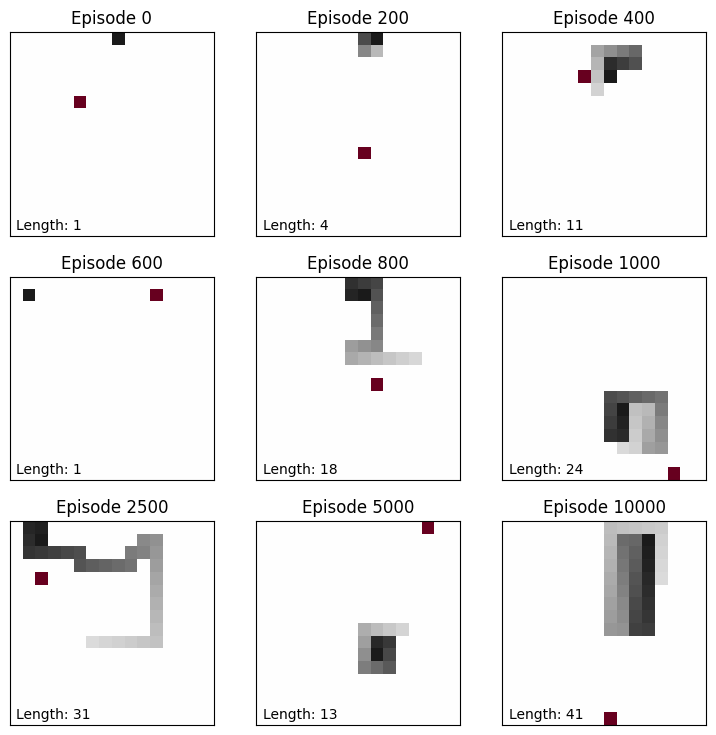

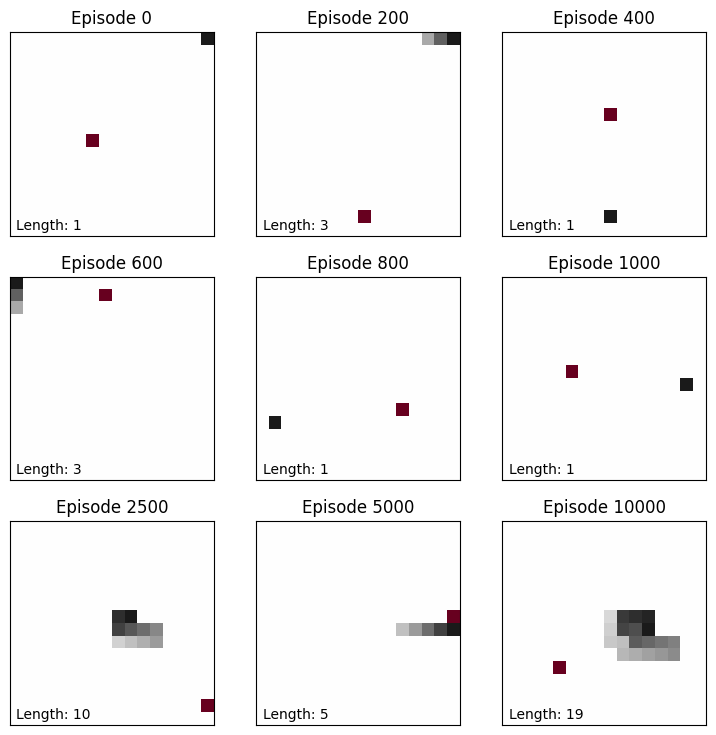

In [16]:
numEpisodes = 10001  # number of games to train for
boardDim = 16  # size of the baord
lr = 0.9 #learning rate
gamma = 0.8  # discount rate
epsilon = 0.2  # exploration rate in training games

Qs = QLearning(numEpisodes,boardDim,lr,gamma,epsilon)
ani = generate_plot(Qs, boardDim)

Qs2 = Sarsa(numEpisodes,boardDim,lr,gamma,epsilon)
ani2 = generate_plot(Qs2, boardDim)

HTML(ani.to_html5_video())
HTML(ani2.to_html5_video())